# Load Data and Word-Embedding Models

In [1]:
import os
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train.json', 'r'))
val_data = json.load(open('NER_val.json', 'r'))
test_data = json.load(open('NER_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
random_vector = {}
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('random')
        if size not in random_vector:
            random_vector[size] = torch.randn(size)
        return random_vector[size]

# GRU Implementation

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.gru = nn.GRU(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out

# Training and Validation Code

In [4]:

import re

def clean_word(word):
    import string
    # Removing all punctuation characters using a translation table
    clean_word = word.translate(str.maketrans('', '', string.punctuation))
    # Stripping whitespace and newline characters
    clean_word = clean_word.strip()
    
    # Convert an empty string to a whitespace of equivalent length of the original word
    if not clean_word:
        return ' ' * len(word)
    else:
        return clean_word

def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cpu', epochs=10):
    label_mapping = {"B_PRECEDENT": 0, "I_RESPONDENT": 1, "I_GPE": 2, "B_GPE": 3, "I_PROVISION": 4, "I_STATUTE": 5, "I_WITNESS": 6, "I_ORG": 7, "O": 8, "B_JUDGE": 9, "B_WITNESS": 10, "B_COURT": 11, "B_PETITIONER": 12, "I_PRECEDENT": 13, "B_CASE_NUMBER": 14, "B_OTHER_PERSON": 15, "B_PROVISION": 16, "I_COURT": 17, "I_JUDGE": 18, "I_DATE": 19, "B_ORG": 20, "B_STATUTE": 21, "I_PETITIONER": 22, "I_OTHER_PERSON": 23, "I_CASE_NUMBER": 24, "B_RESPONDENT": 25, "B_DATE": 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            # text = data["text"].split()
            pattern = r'[ ]+'
            text = re.split(pattern, data["text"])
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                # text = data["text"].split()
                pattern = r'[ ]+'
                text = re.split(pattern, data["text"])
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Testing Code

In [5]:
def test(model, embedding_model, test_data, device='cpu'):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B_PRECEDENT": 0, "I_RESPONDENT": 1, "I_GPE": 2, "B_GPE": 3, "I_PROVISION": 4, "I_STATUTE": 5, "I_WITNESS": 6, "I_ORG": 7, "O": 8, "B_JUDGE": 9, "B_WITNESS": 10, "B_COURT": 11, "B_PETITIONER": 12, "I_PRECEDENT": 13, "B_CASE_NUMBER": 14, "B_OTHER_PERSON": 15, "B_PROVISION": 16, "I_COURT": 17, "I_JUDGE": 18, "I_DATE": 19, "B_ORG": 20, "B_STATUTE": 21, "I_PETITIONER": 22, "I_OTHER_PERSON": 23, "I_CASE_NUMBER": 24, "B_RESPONDENT": 25, "B_DATE": 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            # text = data["text"].split()
            pattern = r'[ ]+'
            text = re.split(pattern, data["text"])
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    return accuracy, f1

In [6]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [7]:
input_size = 300  # Embedding size
hidden_size = 64  # Hidden size of the RNN
output_size = 27   # BIO encoding: B, I, O

# For Word2Vec Embeddings

In [8]:
gru_word2vec_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_word2vec_model.parameters(), lr=0.001)

In [9]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cpu', epochs=10)

Epoch 1/10
Training: Loss: 0.3809, Accuracy: 0.9062, F1: 0.3953
Validation: Loss: 0.2775, Accuracy: 0.9283, F1: 0.4958
Epoch 2/10
Training: Loss: 0.2511, Accuracy: 0.9312, F1: 0.5436
Validation: Loss: 0.2500, Accuracy: 0.9348, F1: 0.5604
Epoch 3/10
Training: Loss: 0.2140, Accuracy: 0.9397, F1: 0.6226
Validation: Loss: 0.2409, Accuracy: 0.9372, F1: 0.6014
Epoch 4/10
Training: Loss: 0.1880, Accuracy: 0.9457, F1: 0.6684
Validation: Loss: 0.2375, Accuracy: 0.9380, F1: 0.6230
Epoch 5/10
Training: Loss: 0.1675, Accuracy: 0.9507, F1: 0.7066
Validation: Loss: 0.2413, Accuracy: 0.9373, F1: 0.6187
Epoch 6/10
Training: Loss: 0.1501, Accuracy: 0.9548, F1: 0.7330
Validation: Loss: 0.2495, Accuracy: 0.9366, F1: 0.6152
Epoch 7/10
Training: Loss: 0.1367, Accuracy: 0.9587, F1: 0.7570
Validation: Loss: 0.2546, Accuracy: 0.9361, F1: 0.6124
Epoch 8/10
Training: Loss: 0.1259, Accuracy: 0.9615, F1: 0.7741
Validation: Loss: 0.2652, Accuracy: 0.9353, F1: 0.6049
Epoch 9/10
Training: Loss: 0.1165, Accuracy: 0.9

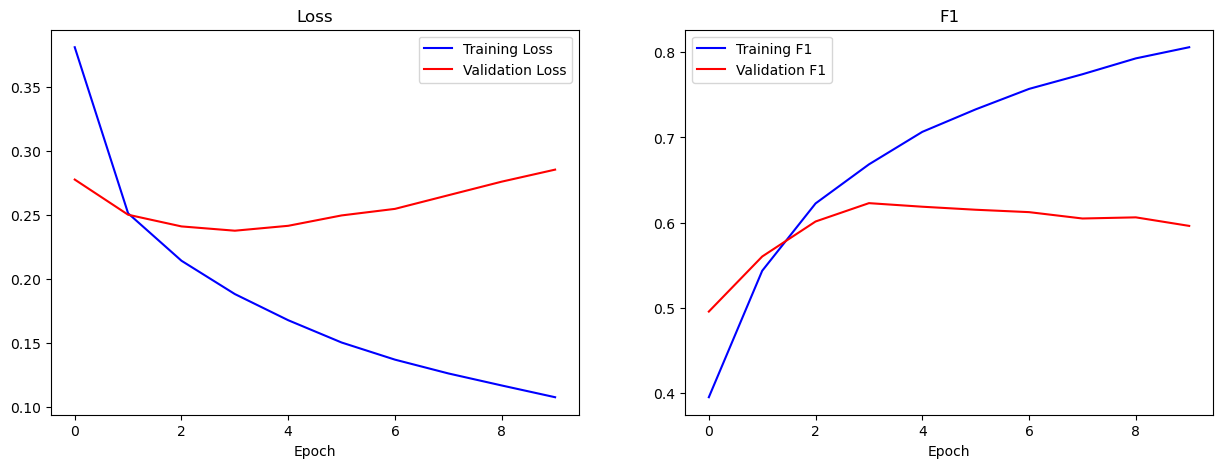

In [10]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [11]:
torch.save(gru_word2vec_model, "t1_model3_word2vec.pt")

In [12]:
test_accuracy, test_f1 = test("t1_model3_word2vec.pt", word2vec, test_data, device='cpu')
print(("GRU with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

GRU with Word2Vec ==> Accuracy: 0.9307, F1: 0.5840


# For GloVe Embeddings

In [13]:
gru_glove_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_glove_model.parameters(), lr=0.001)

In [14]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_glove_model, glove, train_data, val_data, criterion, optimizer, device='cpu', epochs=10)

Epoch 1/10
Training: Loss: 0.5029, Accuracy: 0.8766, F1: 0.2045
Validation: Loss: 0.4195, Accuracy: 0.8929, F1: 0.2816
Epoch 2/10
Training: Loss: 0.4041, Accuracy: 0.8947, F1: 0.3248
Validation: Loss: 0.3978, Accuracy: 0.8959, F1: 0.3618
Epoch 3/10
Training: Loss: 0.3790, Accuracy: 0.8995, F1: 0.3855
Validation: Loss: 0.3944, Accuracy: 0.8970, F1: 0.3918
Epoch 4/10
Training: Loss: 0.3640, Accuracy: 0.9029, F1: 0.4123
Validation: Loss: 0.3912, Accuracy: 0.8971, F1: 0.4033
Epoch 5/10
Training: Loss: 0.3524, Accuracy: 0.9052, F1: 0.4280
Validation: Loss: 0.3944, Accuracy: 0.8974, F1: 0.4046
Epoch 6/10
Training: Loss: 0.3432, Accuracy: 0.9077, F1: 0.4459
Validation: Loss: 0.3952, Accuracy: 0.8974, F1: 0.4170
Epoch 7/10
Training: Loss: 0.3350, Accuracy: 0.9094, F1: 0.4564
Validation: Loss: 0.3990, Accuracy: 0.8963, F1: 0.4057
Epoch 8/10
Training: Loss: 0.3270, Accuracy: 0.9115, F1: 0.4675
Validation: Loss: 0.4027, Accuracy: 0.8969, F1: 0.4138
Epoch 9/10
Training: Loss: 0.3198, Accuracy: 0.9

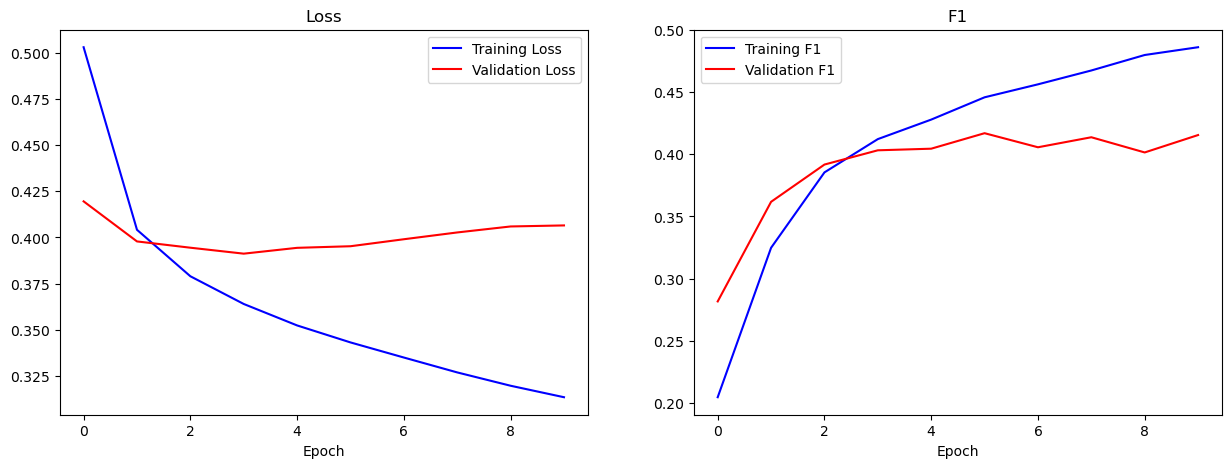

In [15]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [16]:
torch.save(gru_glove_model, "t1_model3_glove.pt")

In [17]:
test_accuracy, test_f1 = test("t1_model3_glove.pt", glove, test_data, device='cpu')
print(("GRU with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

GRU with GloVe ==> Accuracy: 0.8960, F1: 0.3926


# For FastText Embeddings

In [18]:
gru_fasttext_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_fasttext_model.parameters(), lr=0.001)

In [19]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        gru_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cpu', epochs=10)

Epoch 1/10
Training: Loss: 0.4070, Accuracy: 0.8999, F1: 0.3451
Validation: Loss: 0.2784, Accuracy: 0.9254, F1: 0.4370
Epoch 2/10
Training: Loss: 0.2553, Accuracy: 0.9294, F1: 0.4755
Validation: Loss: 0.2452, Accuracy: 0.9331, F1: 0.4950
Epoch 3/10
Training: Loss: 0.2219, Accuracy: 0.9365, F1: 0.5371
Validation: Loss: 0.2306, Accuracy: 0.9363, F1: 0.5478
Epoch 4/10
Training: Loss: 0.1992, Accuracy: 0.9423, F1: 0.5960
Validation: Loss: 0.2222, Accuracy: 0.9385, F1: 0.5827
Epoch 5/10
Training: Loss: 0.1806, Accuracy: 0.9468, F1: 0.6428
Validation: Loss: 0.2175, Accuracy: 0.9407, F1: 0.6036
Epoch 6/10
Training: Loss: 0.1647, Accuracy: 0.9505, F1: 0.6716
Validation: Loss: 0.2161, Accuracy: 0.9407, F1: 0.6109
Epoch 7/10
Training: Loss: 0.1515, Accuracy: 0.9538, F1: 0.6996
Validation: Loss: 0.2186, Accuracy: 0.9407, F1: 0.6201
Epoch 8/10
Training: Loss: 0.1402, Accuracy: 0.9570, F1: 0.7225
Validation: Loss: 0.2211, Accuracy: 0.9408, F1: 0.6208
Epoch 9/10
Training: Loss: 0.1303, Accuracy: 0.9

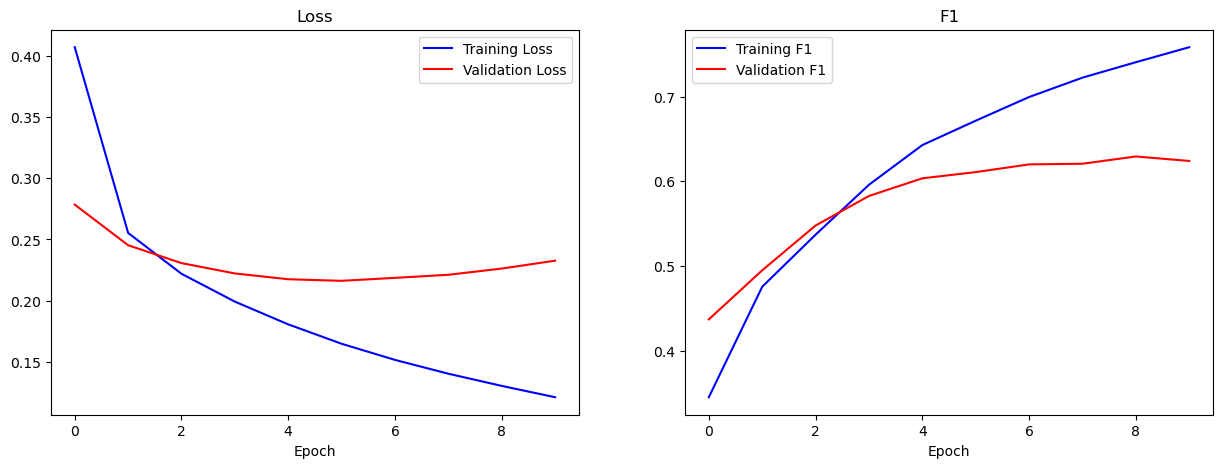

In [20]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [21]:
torch.save(gru_fasttext_model, "t1_model3_fasttext.pt")

In [23]:
test_accuracy, test_f1 = test("t1_model3_fasttext.pt", fasttext, test_data, device='cpu')
print(("GRU with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

GRU with FastText ==> Accuracy: 0.9404, F1: 0.6083
